Let's do an exercise connecting previous domains. We will:

* Get the data from the MNIST digit classification challenge
* Reduce the dimensionality of the images by using the t-SNE technique
* Select a feature map (quantum FM) of our liking
* And build a classifier with it (QSVC in this case)

In [1]:
import numpy as np

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
X, y = load_digits(return_X_y=True)

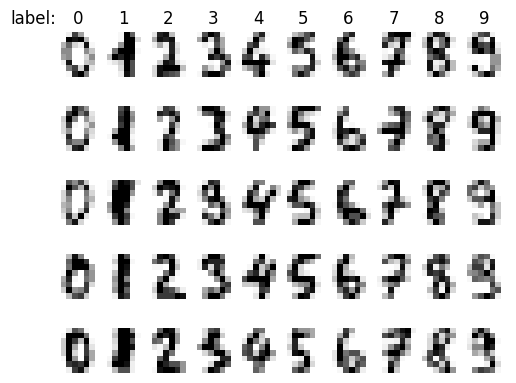

In [3]:
from visualize import plot_dataset

plot_dataset(X, y, rows=5)

In [4]:
X_tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=40).fit_transform(X)

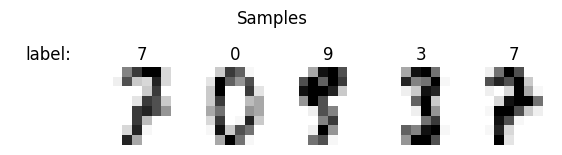

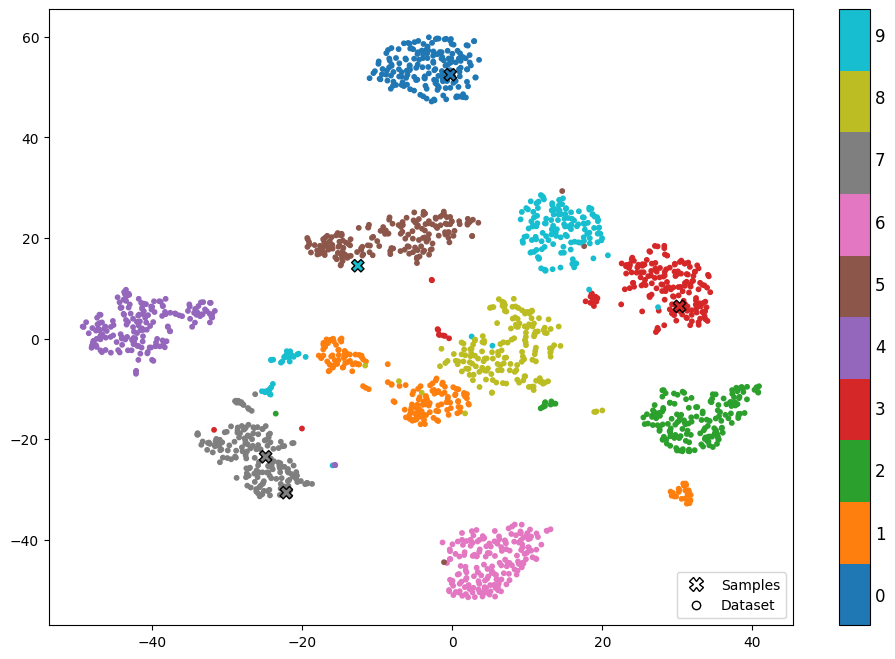

In [5]:
from visualize import plot_numbers, plot_data_in_feature_space

rows = np.random.choice(np.arange(1000, X.shape[0]), 5, replace=False)
plot_numbers(X[rows, :], y[rows], title="label:")

plot_data_in_feature_space(X_tsne, y, highlight_rows=rows)

In [6]:
n_samples = 1000

X_train, X_test, y_train, y_test = train_test_split(
    X_tsne[:n_samples, :],
    y[:n_samples],
    test_size=0.33,
    random_state=42,
)

In [7]:
scaler = MinMaxScaler((-0.9, 0.9))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
import pennylane as qml

N = 2 # Classical data dimensions
wires = range(N)
dev = qml.device("default.qubit", wires)

@qml.qnode(dev)
def circuit(features):
    qml.IQPEmbedding(features, wires, n_repeats=2)
    return qml.state()

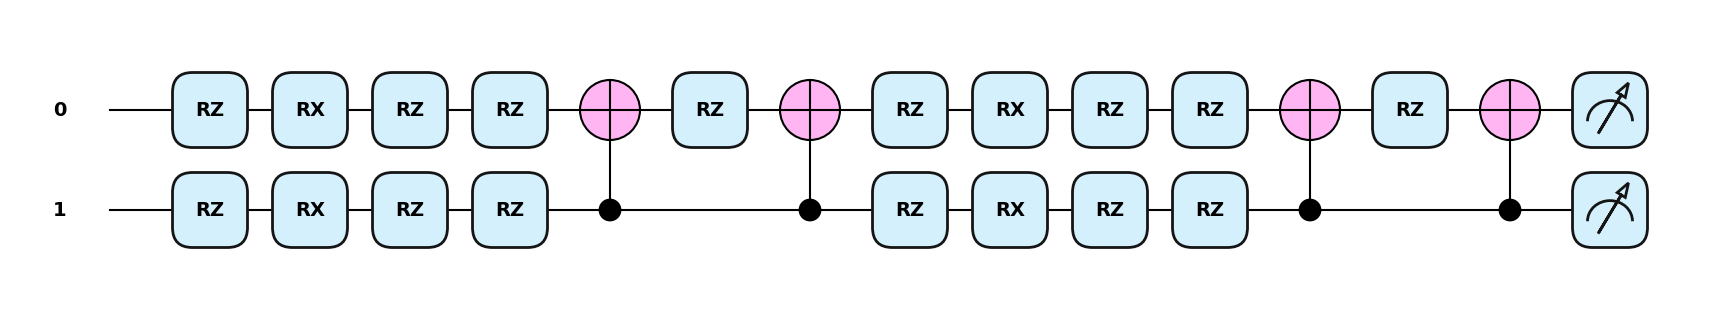

In [9]:
qdecomp = qml.transforms.decompose(circuit, gate_set={qml.CNOT, qml.RZ, qml.RX})

qml.drawer.use_style("pennylane")
qml.draw_mpl(qdecomp)(X_train[0]);

In [10]:
def embedding(x, wires):
    """The embedding ansatz"""
    qml.IQPEmbedding(x, wires, n_repeats=2)

adjoint_embedding = qml.adjoint(embedding)

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    embedding(x1, wires)
    adjoint_embedding(x2, wires)
    return qml.probs(wires=wires)

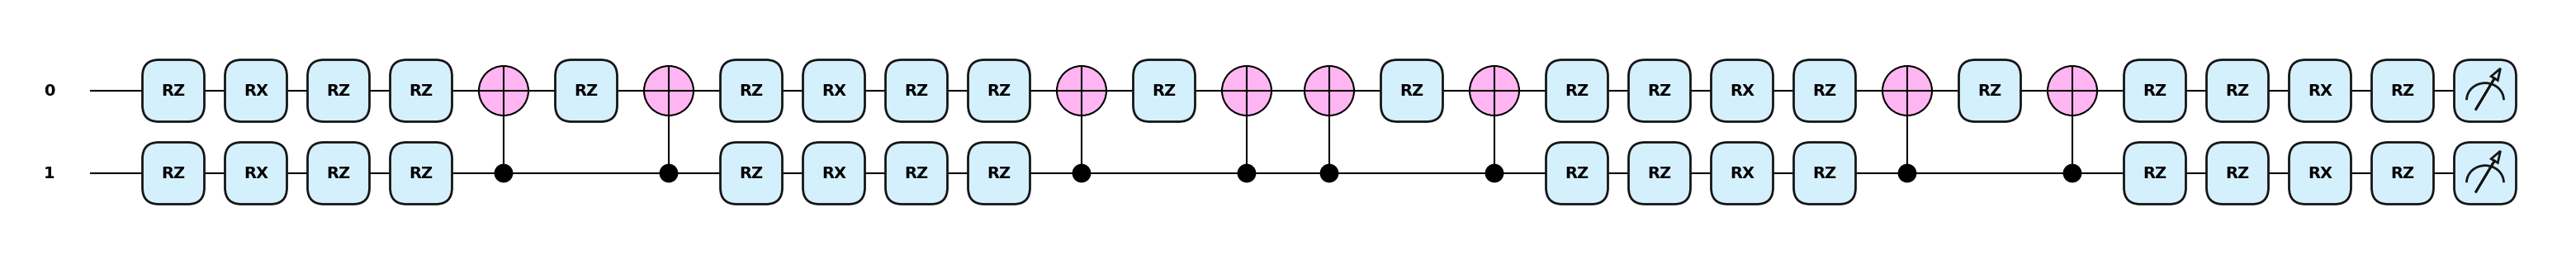

In [11]:
qdecomp = qml.transforms.decompose(kernel_circuit, gate_set={qml.CNOT, qml.RZ, qml.RX})

qml.draw_mpl(qdecomp)(X_train[0], X_train[1]);

In [20]:
def kernel_matrix(A, B):
    return np.array([[kernel_circuit(a, b)[0] for b in B] for a in A])

kernel_matrix(X_train[:5], X_train[:5])

array([[1.        , 0.75652261, 0.94668374, 0.99367851, 0.75625093],
       [0.75652261, 1.        , 0.83807413, 0.72967456, 0.99968961],
       [0.94668374, 0.83807413, 1.        , 0.91003443, 0.84202934],
       [0.99367851, 0.72967456, 0.91003443, 1.        , 0.72841311],
       [0.75625093, 0.99968961, 0.84202934, 0.72841311, 1.        ]])

In [21]:
from sklearn.svm import SVC

svm = SVC(kernel=kernel_matrix)
svm.fit(X_train, y_train)

SVC(kernel=<function kernel_matrix at 0x7b3b7006db20>)

In [22]:
predictions = svm.predict(X_train)
print(f"Train accuracy score {accuracy_score(y_train, predictions)}")
predictions = svm.predict(X_test)
print(f"Test accuracy score {accuracy_score(y_test, predictions)}")

Train accuracy score 0.9223880597014925
Test accuracy score 0.9484848484848485


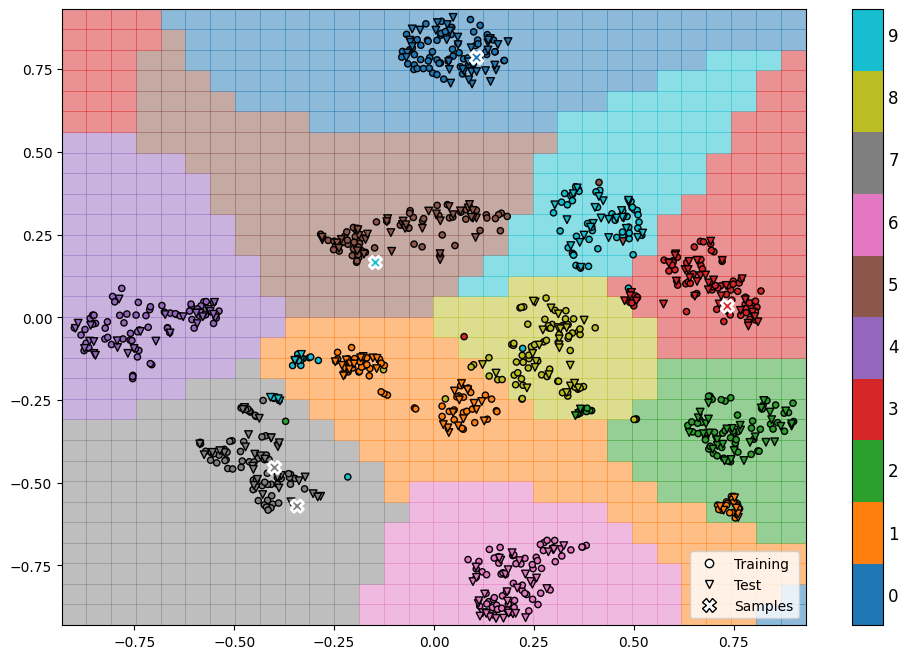

In [23]:
from visualize import plot_results

plot_results(
    clf=svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_highlight=scaler.transform(X_tsne[rows]),
    y_highlight=y[rows],
    X_range=[(-0.9, 0.9), (-0.9, 0.9)],
    resolution=30,
)

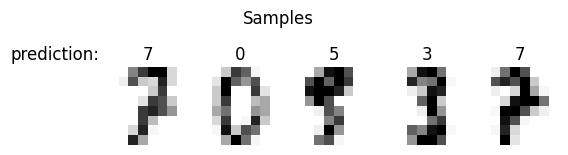

In [24]:
y_pred = svm.predict(scaler.transform(X_tsne[rows, :]))

plot_numbers(X[rows, :], y_pred, title="prediction:")